# 19 Monte Carlo methods

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

#### Excercise 1
Extend the 1D model to a 2D lattice of $10\times10$ spins (or larger if you have a good computer), where the spins can point only in the + or - $y$ direction. The system energy is the sum of all interactions between nearest neigbors on the lattice.

$$E=-J\sum_{\langle i,j\rangle}s_is_j$$
where the notation $\langle i,j\rangle$ indicates a sum over pairs $i,j$ that are adjacent on the lattice.

The goal is to show the net magnetization (and uncertainty) as a function of temperature. How does the critical temperature change?

In [72]:
# Define some constants
J = 1
N = 15


In [73]:
# Initialize spins array
@nb.jit(forceobj=True)
def initialize_spins(N):
    return np.random.choice([-1, 1], size=(N, N))

# Magnetization of the system
@nb.jit(nopython=True)
def magnetization(s):
    return np.sum(s)

# Energy of the nearest neighbor interaction
@nb.jit(nopython=True)
def energy(s):
    E = 0
    for i in range(N):
        for j in range(N):
            if i == 0:
                if j == N-1:
                    e = s[i, j] * s[i+1, j]
                else:
                    e = s[i, j] * (s[i+1, j] + s[i, j+1])
            if i == N-1:
                if j == N-1:
                    e = 0
                else:
                    e = s[i, j] * s[i, j+1]
            else:
                if j == N-1:
                    e = s[i, j] * s[i+1, j]
                else:
                    e = s[i, j] * (s[i+1, j] + s[i, j+1])

            E += -J * e
    return E

# Step of the simulation
@nb.jit(forceobj=True)
def do_step(spins, temp, steps=100, print_steps=False) -> None:

    # Initialize the energy and magnetization
    E = energy(spins)
    M = magnetization(spins)

    # Loop over the number of steps
    accepted = 0
    for _ in range(steps):
        # Choose a random spin
        i = np.random.randint(N)
        j = np.random.randint(N)
        # Flip the spin
        spins[i, j] *= -1
        E_last = E
        E = energy(spins)
        dE = E - E_last

        if dE > 0:
            if np.random.random() > np.exp(-dE/temp):
                spins[i, j] *= -1
                E = E_last
            else:
                accepted += 1

    if print_steps:
        print("\nEnergy =", E, "Magnetization =", M)
        print("Acceptance rate:", 100.0*accepted/steps, "%")
    
    return None

# Running the MC simulation
@nb.jit(forceobj=True)
def simulate(spins, temp, iters=50, steps=100, print_steps=False):
    E = energy(spins)
    M = magnetization(spins)
    E_list = np.empty(iters + 1)
    M_list = np.empty(iters + 1)
    E_list[0] = E
    M_list[0] = M
    
    for i in range(iters):
        do_step(spins, temp, steps=steps, print_steps=print_steps)
        E_list[i+1] = energy(spins)
        M_list[i+1] = magnetization(spins)
    
    return np.average(E_list), np.average(M_list), np.std(E_list), np.std(M_list)


In [75]:
@nb.jit(nopython=False, forceobj=True)
def simulation(T0, T1, N_T):
    T = np.linspace(T0, T1, N_T)

    spins = np.array([
        initialize_spins(N)
        for _ in range(N_T)
    ])
    E_avgs = np.empty(N_T)
    M_avgs = np.empty(N_T)
    E_stds = np.empty(N_T)
    M_stds = np.empty(N_T)
    for i in range(N_T):
        do_step(spins[i], T[0], steps=100000)
        E_avgs[i], M_avgs[i], E_stds[i], M_stds[i] = simulate(spins[i], T[i], iters=50, steps=10000, print_steps=False)
        print("Temperature =", round(T[i], 3), "Finished")

    return T, E_avgs, M_avgs, E_stds, M_stds


In [76]:
T, E_avgs, M_avgs, E_stds, M_stds = simulation(0.001, 2.5, 30)

Temperature = 0.001 Finished
Temperature = 0.087 Finished
Temperature = 0.173 Finished
Temperature = 0.26 Finished
Temperature = 0.346 Finished
Temperature = 0.432 Finished
Temperature = 0.518 Finished
Temperature = 0.604 Finished
Temperature = 0.69 Finished
Temperature = 0.777 Finished
Temperature = 0.863 Finished
Temperature = 0.949 Finished
Temperature = 1.035 Finished
Temperature = 1.121 Finished
Temperature = 1.207 Finished
Temperature = 1.294 Finished
Temperature = 1.38 Finished
Temperature = 1.466 Finished
Temperature = 1.552 Finished
Temperature = 1.638 Finished
Temperature = 1.724 Finished
Temperature = 1.811 Finished
Temperature = 1.897 Finished
Temperature = 1.983 Finished
Temperature = 2.069 Finished
Temperature = 2.155 Finished
Temperature = 2.241 Finished
Temperature = 2.328 Finished
Temperature = 2.414 Finished
Temperature = 2.5 Finished


In [77]:
print(
    T.shape,
    E_avgs.shape,
    M_avgs.shape,
    E_stds.shape,
    M_stds.shape
)

(30,) (30,) (30,) (30,) (30,)


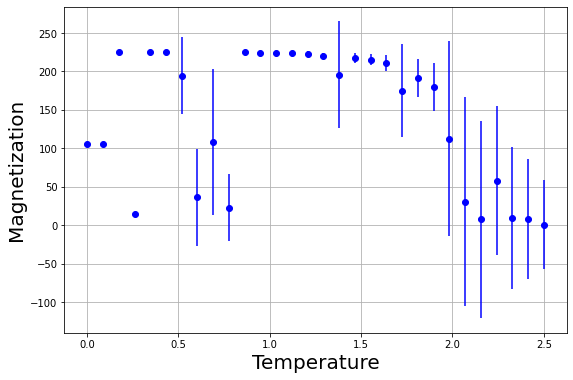

In [80]:
plt.figure(figsize=(9, 6))
plt.errorbar(T, np.abs(M_avgs), yerr=M_stds, fmt="bo")
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization", fontsize=20)
plt.grid()
plt.show()
plt.close()


T = 1.638 Finished
T = 1.38 Finished
T = 0.69 Finished
T = 1.294 Finished
T = 0.949 Finished
T = 0.346 Finished
T = 1.552 Finished
T = 1.466 Finished
T = 1.207 Finished
T = 0.604 Finished
T = 0.26 Finished
T = 0.432 Finished
T = 0.863 Finished
T = 1.121 Finished
T = 1.035 Finished
T = 0.777 Finished
T = 0.173 Finished
T = 0.001 Finished
T = 0.087 Finished
T = 0.518 Finished
T = 1.724 Finished
T = 1.811 Finished
T = 1.897 Finished
T = 2.069 Finished
T = 2.241 Finished
T = 2.414 Finished
T = 2.155 Finished
T = 2.328 Finished
T = 1.983 Finished
T = 2.5 Finished


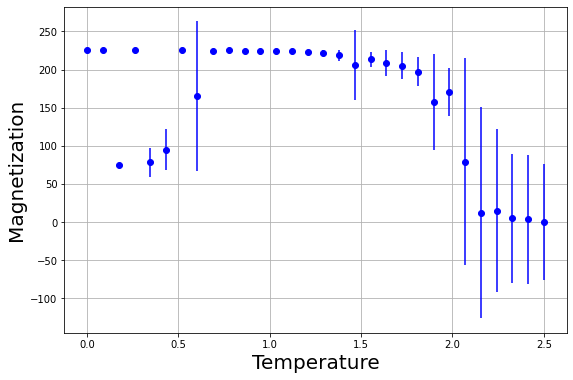

In [3]:
from scripts import simulation
import numpy as np
import matplotlib.pyplot as plt

T, E_avgs, M_avgs, E_stds, M_stds = simulation(
    T0=0.001, 
    T1=2.5, 
    N_T=30,
    N_S=15,
    J=1,
    iters=60,
    steps=20_000,
    print_steps=False
)

plt.figure(figsize=(9, 6))
plt.errorbar(T, np.abs(M_avgs), yerr=M_stds, fmt="bo")
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization", fontsize=20)
plt.grid()
plt.show()
plt.close()